In [ ]:
!pip install dm-haiku
!pip install optax
import dataclasses
import haiku as hk
import jax
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow_datasets as tfds
import tqdm
from typing import Tuple
from typing import Tuple

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
def load_mnist() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
  train_ds = tfds.load('mnist', split='train', as_supervised=True)
  train_ds = train_ds.map(preprocess).shuffle(1024).batch(128)
  test_ds = tfds.load('mnist', split='test', as_supervised=True)
  test_ds = test_ds.map(preprocess).batch(128)
  train_images, train_labels = next(iter(train_ds))
  test_images, test_labels = next(iter(test_ds))
  train_images = np.array(train_images).reshape(-1, 28 * 28)
  train_labels = np.array(train_labels)
  test_images = np.array(test_images).reshape(-1, 28 * 28)
  test_labels = np.array(test_labels)
  return train_images, train_labels, test_images, test_labels

def preprocess(x, y):
  x = tf.image.convert_image_dtype(x, tf.float32)
  return x, y

In [ ]:
def shadow_models(dataset: np.ndarray, targets:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  rng = hk.PRNGSequence(42)
  params = []

  for target in tqdm.tqdm(targets):
    net = hk.Sequential([hk.Linear(512), jax.nn.relu,
                         hk.Linear(512), jax.nn.relu,
                         hk.Linear(10)])
    opt = optax.adam(1e-3)
    opt_state = opt.init(net.params)
    loss_fn = jax.nn.softmax_cross_entropy_with_logits

  for _ in range(50):
    idx = np.random.choice(len(dataset), size=128, replace=False)
    x, y = dataset[idx], targets[idx]
    y_one = np.eye(10)[y]
    grads = jax.grad(loss_fn)(net.params, x, y_one)

In [ ]:
shadow_model_lr = 1e-1
shadow_model_seed = 0
num_shadow_model_epochs = 30
num_in_shadow_train = 5000
num_in_shadow_eval = 1000

def shadow_model_forward(images):
  """Shadow model architecture."""
  net = hk.nets.MLP([10, 10], activation=jax.nn.elu,
  activate_final=False)
  return net(images)

shadow_model = hk.without_apply_rng(hk.transform(shadow_model_forward))
opt_init, opt_update = optax.sgd(shadow_model_lr, momentum=0.9)
# Next, we define functions to train the shadow models and calculate their accuracy.
@jax.jit
def xe_loss(params, images, labels):
  """Cross-entropy loss."""
  batch_size = images.shape[0]
  logits = shadow_model.apply(params, images)
  log_probs = jax.nn.log_softmax(logits)
  return -jnp.sum(hk.one_hot(labels, 10) * log_probs) / batch_size

@jax.jit
def shadow_model_accuracy(params, images, labels):
  """Prediction accuracy."""
  predictions = shadow_model.apply(params, images)
  return jnp.mean(jnp.argmax(predictions, axis=-1) == labels)

@jax.jit
def shadow_model_update(params, opt_state, images_batch, labels_batch):
  gradient = jax.grad(xe_loss)(params, images_batch, labels_batch)
  updates, opt_state = opt_update(gradient, opt_state)
  new_params = optax.apply_updates(params, updates)

In [ ]:
reconstructor_training_epochs = 200  #@param {type:"integer"}
reconstructor_lr = 3e-4  #@param {type:"number"}

# Define the reconstructor network architecture.
def reconstructor_network_forward(params):
  """Reconstructor network architecture."""
  net = hk.nets.MLP([1000, 1000, 784], activation=jax.nn.relu, activate_final=False)
  return net(params)

# Set up the reconstructor network and optimizer.
reconstructor_network = hk.without_apply_rng(hk.transform(reconstructor_network_forward))
opt_init, opt_update = optax.rmsprop(reconstructor_lr)

In [ ]:
# Define the loss functions for the reconstructor network.
@jax.jit
def mse_loss(reconstructor_params, params_batch, images_batch):
  """MSE loss between reconstruction and target."""
  batch_size = params_batch.shape[0]
  images_batch_logits = reconstructor_network.apply(reconstructor_params, params_batch)
  images_batch_pred = jax.nn.sigmoid(images_batch_logits)
  return jnp.mean(jnp.mean((images_batch_pred - images_batch)**2, axis=1))

@jax.jit
def mae_loss(reconstructor_params, params_batch, images_batch):
  """MAE loss between reconstruction and target."""
  batch_size = params_batch.shape[0]
  images_batch_logits = reconstructor_network.apply(reconstructor_params, params_batch)
  images_batch_pred = jax.nn.sigmoid(images_batch_logits)
  return jnp.mean(jnp.mean(jnp.abs(images_batch_pred - images_batch), axis=1))

@jax.jit
def mse_and_mae_loss(reconstructor_params, params_batch, images_batch):
  """MSE and MAE loss between reconstruction and target."""
  mae = mae_loss(reconstructor_params,
  params_batch, images_batch)
  mse = mse_loss(reconstructor_params,
  params_batch, images_batch)
  return mae + mse, (mae, mse)

# Define the update function for the reconstructor network.
def reconstructor_network_update(reconstructor_params, opt_state, params_batch, images_batch):
  (loss, (_, _)), gradient = jax.value_and_grad(mse_and_mae_loss, has_aux=True)(reconstructor_params, params_batch,
images_batch)
  updates, opt_state = opt_update(gradient, opt_state)
  new_reconstructor_params = optax.apply_updates(reconstructor_params, updates)
  return new_reconstructor_params, opt_state, loss


**From paper**

In [ ]:
!pip install dm-haiku
!pip install optax

import dataclasses
import haiku as hk
import jax
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
import numpy as np
import optax

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import utils
import tensorflow_datasets as tfds
import tqdm
from typing import Tuple

In [ ]:
# Number of samples for shadow model evaluation.
num_samples_mnist_prediction_eval=1200 #@param {type:"integer"}

# Number of samples in fixed dataset.
num_in_fixed=1000 #@param {type:"integer"}

# Number of samples in reconstruction evaluation set.
num_in_shadow_eval=1000 #@param {type:"integer"}

# Number of shadow models used to train the reconstructor network. Making this
# larger will improve reconstructions at the expense of longer training times.
# Maximum value will be (70_000 - num_in_fixed - num_in_eval -
# num_samples_mnist_prediction_eval).
num_in_shadow_train=12000 #@param {type:"integer"}

# MNIST data is shuffled using this seed. Used to create a consistent
# shadow dataset.
shadow_data_seed=40 #@param {type:"integer"}

# Shadow models are all initialized with the same parameters using this seed.
shadow_model_seed=40 #@param {type:"integer"}

# Number of shadow model training epochs.
num_shadow_model_epochs=120 #@param {type:"integer"}

# Shadow model learning rate.
shadow_model_lr=1e-1 #@param {type:"number"}

In [ ]:
@dataclasses.dataclass(frozen=True)
class ShadowDataset:
  images: np.ndarray
  labels: np.ndarray

@dataclasses.dataclass(frozen=True)
class ReconstructionDataset:
  params: np.ndarray
  images: np.ndarray

def mnist_load_helper(split):
  """Loads a subset of the mnist dataset, reshapes, and normalizes images."""
  ds = tfds.load(
      'mnist',
      split=split,
      batch_size=-1,
      shuffle_files=False,
      as_supervised=True,
      with_info=False,
      try_gcs=True)
  ds_numpy = tfds.as_numpy(ds)
  images, labels = ds_numpy
  images_normalized = (images / 255).reshape([images.shape[0], 784])
  return images_normalized, labels


def load_data(
    seed: int = 42,
    num_samples_mnist_prediction_eval: int = 1000,
    num_in_fixed: int = 1000,
    num_in_shadow_eval: int = 900,
    num_in_shadow_train: int = 9900,
) -> Tuple[ShadowDataset, ShadowDataset, ShadowDataset, ShadowDataset]:
  """Data loading used for shadow model creation.

  There is a constraint on num_samples_mnist_prediction_eval+ num_in_fixed +
  num_in_shadow_eval + num_in_shadow_train. Specifically, the sum should be less
  than or equal to the size of the MNIST dataset (70K) examples.

  Args:
    seed: (int) The seed used to shuffle the entire dataset before splitting.
    num_samples_mnist_prediction_eval: (int) The number of samples on which each
      shadow model is evaluated.
    num_in_fixed: (int) The number of samples in the fixed dataset.
    num_in_shadow_eval: (int) The number of targets that will be used to
      evaluate the reconstructor network.
    num_in_shadow_train: (int) The number of targets that will be used to train
      the reconstructor network.

  Returns:
    A tuple (fixed_set, shadow_train, shadow_eval, test_set),
    where each is a ShadowDataset with fields 'images' and 'labels' set.
  """
  rng = np.random.default_rng(seed)

  # Load all of the MNIST dataset and shuffle.
  images_main, labels_main = mnist_load_helper('train+test')
  idxs = rng.permutation(len(labels_main))
  images_main = images_main[idxs]
  labels_main = labels_main[idxs]

  total_data_size = (
      num_samples_mnist_prediction_eval + num_in_shadow_eval + num_in_fixed +
      num_in_shadow_train)
  if len(images_main) < total_data_size:
    raise ValueError(
        'num_samples_mnist_prediction_eval + num_in_shadow_eval + num_in_fixed '
        f'+ num_in_shadow_train is {total_data_size}, but should be '
        f'less than {len(images_main)}.')

  # Reserve first 'num_samples_mnist_prediction_eval' samples to evaluate
  # shadow model. The following 'num_in_shadow_eval' samples are used to
  # evaluate the reconstructor network. The next 'num_in_fixed' samples are
  # assigned to the fixed dataset. The next 'num_in_shadow_train' will be
  # targets for training the reconstructor network.
  split_points = np.cumsum([
      num_samples_mnist_prediction_eval,
      num_in_shadow_eval,
      num_in_fixed,
      num_in_shadow_train,
  ])
  (mnist_eval_images, shadow_eval_images, images_fixed, shadow_train_images,
   _) = np.split(images_main, split_points)
  (mnist_eval_labels, shadow_eval_labels, labels_fixed, shadow_train_labels,
   _) = np.split(labels_main, split_points)

  mnist_eval = ShadowDataset(images=mnist_eval_images, labels=mnist_eval_labels)
  fixed_set = ShadowDataset(images=images_fixed, labels=labels_fixed)
  shadow_train_data = ShadowDataset(
      images=shadow_train_images, labels=shadow_train_labels)
  shadow_eval_data = ShadowDataset(
      images=shadow_eval_images, labels=shadow_eval_labels)

  return fixed_set, shadow_train_data, shadow_eval_data, mnist_eval


fixed_set, shadow_train_data, shadow_eval_data, mnist_eval = load_data(
    seed=shadow_data_seed,
    num_in_fixed=num_in_fixed,
    num_in_shadow_eval=num_in_shadow_eval,
    num_in_shadow_train=num_in_shadow_train,
)

print('Number of shadow models for '
      f'(reconstruction) training set: {len(shadow_train_data.images)}')
print('Number of shadow models for '
      f'(reconstruction) evaluation set: {len(shadow_eval_data.images)}')

Number of shadow models for (reconstruction) training set: 12000
Number of shadow models for (reconstruction) evaluation set: 1000


In [ ]:
def shadow_model_forward(images):
  """Shadow model architecture."""
  net = hk.nets.MLP([10, 10], activation=jax.nn.elu, activate_final=False)
  return net(images)


# Define shadow model and optimizer.
shadow_model = hk.without_apply_rng(hk.transform(shadow_model_forward))
opt_init, opt_update = optax.sgd(shadow_model_lr, momentum=0.9)


@jax.jit
def xe_loss(params, images, labels):
  """Cross-entropy loss."""
  batch_size = images.shape[0]
  logits = shadow_model.apply(params, images)
  log_probs = jax.nn.log_softmax(logits)
  return -jnp.sum(hk.one_hot(labels, 10) * log_probs) / batch_size


@jax.jit
def shadow_model_accuracy(params, images, labels):
  """Prediction accuracy."""
  predictions = shadow_model.apply(params, images)
  return jnp.mean(jnp.argmax(predictions, axis=-1) == labels)


@jax.jit
def shadow_model_update(params, opt_state, images_batch, labels_batch):
  gradient = jax.grad(xe_loss)(params, images_batch, labels_batch)
  updates, opt_state = opt_update(gradient, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state


def shadow_model_train(step_fn, images_train, labels_train, images_test,
                       labels_test, num_epochs):
  rng = jax.random.PRNGKey(shadow_model_seed)
  image = jnp.ones([1, len(images_train[-1])])
  params = shadow_model.init(rng, image)
  opt_state = opt_init(params)
  for _ in range(num_epochs):
    params, opt_state = step_fn(params, opt_state, images_train, labels_train)
  test_acc = shadow_model_accuracy(params, images_test, labels_test)
  return params, test_acc


def create_shadow_model(images, labels, add_position):
  """Generates target and trains shadow model on fixed dataset + target."""
  add_position = jnp.minimum(add_position, len(labels) - 1)
  image_add = jax.lax.dynamic_slice_in_dim(images, add_position, 1)
  label_add = jax.lax.dynamic_slice_in_dim(labels, add_position, 1)
  # Add additional target to training set.
  images_train = jnp.concatenate([fixed_set.images, image_add])
  labels_train = jnp.concatenate([fixed_set.labels, label_add])
  # opt_params structure: [b_0 (1x10), w_0 (784x10), b_1 (1x10), w_1 (10x10)].
  opt_params, test_acc = shadow_model_train(
      step_fn=shadow_model_update,
      images_train=images_train,
      labels_train=labels_train,
      images_test=mnist_eval.images,
      labels_test=mnist_eval.labels,
      num_epochs=num_shadow_model_epochs,
  )
  # jax.flatten_util.ravel_pytree flattens each leaf row-wise and then
  # concatenates all leaves.
  flat_params, _ = jax.flatten_util.ravel_pytree(opt_params)
  return flat_params, image_add, test_acc


def generate_shadow_data(num_shadow_models, images_in, labels_in, chunk_size):
  """Creates a shadow dataset of (parameter, target) pairs."""
  shadow_params = []
  shadow_images = []
  shadow_test_acc = []
  vmap_fn = jax.vmap(create_shadow_model, in_axes=(None, None, 0))
  for batch_idxs in tqdm.tqdm(
      np.split(np.arange(num_shadow_models), num_shadow_models // chunk_size)):
    # vmap create_shadow_model() over different targets.
    params, images, test_acc = vmap_fn(images_in, labels_in, batch_idxs)
    shadow_params.extend(params)
    shadow_images.extend(images)
    shadow_test_acc.extend(test_acc)
  shadow_params = np.array(shadow_params)
  shadow_images = np.array(shadow_images).squeeze(axis=1)
  return shadow_params, shadow_images, shadow_test_acc


# Generate shadow training data.
train_chunk_size = 50
(
    shadow_train_params,
    shadow_train_images,
    shadow_train_test_acc,
) = generate_shadow_data(num_in_shadow_train, shadow_train_data.images,
                         shadow_train_data.labels, train_chunk_size)
# Assign parameters of shadow models.
np.testing.assert_allclose(shadow_train_images, shadow_train_data.images)

# Generate shadow evaluation data.
test_chunk_size = 10
(
    shadow_eval_params,
    shadow_eval_images,
    shadow_eval_test_acc,
) = generate_shadow_data(num_in_shadow_eval, shadow_eval_data.images,
                         shadow_eval_data.labels, test_chunk_size)
# Assign parameters of shadow models.
np.testing.assert_allclose(shadow_eval_images, shadow_eval_data.images)

print('\nAverage test accuracy of shadow (train) models: '
      f'{np.mean(shadow_train_test_acc):.3f}')
print('Average test accuracy of shadow (eval) models: '
      f'{np.mean(shadow_eval_test_acc):.3f}')


100%|██████████| 100/100 [07:12<00:00,  4.33s/it]



Average test accuracy of shadow (train) models: 0.866
Average test accuracy of shadow (eval) models: 0.866


In [ ]:
fit_scaler_with_only_train = True  #@param {type:"boolean"}


def scaler_fn(params_train, params_test, use_train_only=True):
  if use_train_only:
    scaler = preprocessing.StandardScaler().fit(params_train)
  else:
    scaler = preprocessing.StandardScaler().fit(
        np.concatenate([params_train, params_test]))
  params_train_scaled = scaler.transform(params_train)
  params_test_scaled = scaler.transform(params_test)
  return params_train_scaled, params_test_scaled


shadow_train_rescaled_params, shadow_eval_rescaled_params = scaler_fn(
    shadow_train_params,
    shadow_eval_params,
    use_train_only=fit_scaler_with_only_train,
)

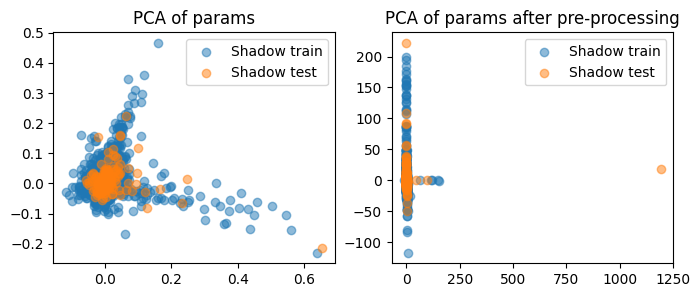

In [ ]:
# PCA on shadow model params
pca = decomposition.PCA(n_components=2)
pca.fit(np.concatenate([shadow_train_params, shadow_eval_params]))
shadow_train_params_pca = pca.transform(shadow_train_params)
shadow_eval_params_pca = pca.transform(shadow_eval_params)

# PCA on rescaled shadow model params
pca = decomposition.PCA(n_components=2)
pca.fit(
    np.concatenate([shadow_train_rescaled_params, shadow_eval_rescaled_params]))
shadow_train_params_scaled_pca = pca.transform(shadow_train_rescaled_params)
shadow_eval_params_scaled_pca = pca.transform(shadow_eval_rescaled_params)

# Plot PCA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
ax1.scatter(
    shadow_train_params_pca[:, 0],
    shadow_train_params_pca[:, 1],
    label='Shadow train',
    alpha=.5)
ax1.scatter(
    shadow_eval_params_pca[:, 0],
    shadow_eval_params_pca[:, 1],
    label='Shadow test',
    alpha=.5)
ax1.set_title('PCA of params')
ax1.legend(loc='best')

ax2.scatter(
    shadow_train_params_scaled_pca[:, 0],
    shadow_train_params_scaled_pca[:, 1],
    label='Shadow train',
    alpha=.5)
ax2.scatter(
    shadow_eval_params_scaled_pca[:, 0],
    shadow_eval_params_scaled_pca[:, 1],
    label='Shadow test',
    alpha=.5)
ax2.set_title('PCA of params after pre-processing')
ax2.legend(loc='best')

# Create new training and eval dataset for reconstruction task.
reconstruction_train_data = ReconstructionDataset(
    params=shadow_train_rescaled_params, images=shadow_train_data.images)
reconstruction_eval_data = ReconstructionDataset(
    params=shadow_eval_rescaled_params, images=shadow_eval_data.images)

In [ ]:
reconstructor_training_epochs = 200  #@param {type:"integer"}
reconstructor_lr = 3e-4  #@param {type:"number"}


def reconstructor_network_forward(params):
  """Reconstructor network architecture."""
  net = hk.nets.MLP([1000, 1000, 784],
                    activation=jax.nn.leaky_relu,
                    activate_final=False)
  return net(params)


# Set-up reconstructor network and optimizer.
reconstructor_network = hk.without_apply_rng(
    hk.transform(reconstructor_network_forward))
opt_init, opt_update = optax.adam(reconstructor_lr)


@jax.jit
def mse_loss(reconstructor_params, params_batch, images_batch):
  """MSE loss between reconstruction and target."""
  batch_size = params_batch.shape[0]
  images_batch_logits = reconstructor_network.apply(reconstructor_params,
                                                  params_batch)
  images_batch_pred = jax.nn.sigmoid(images_batch_logits)
  return jnp.mean(jnp.mean((images_batch_pred - images_batch)**2, axis=1))


@jax.jit
def mae_loss(reconstructor_params, params_batch, images_batch):
  """MAE loss between reconstruction and target."""
  batch_size = params_batch.shape[0]
  images_batch_logits = reconstructor_network.apply(reconstructor_params,
                                                  params_batch)
  images_batch_pred = jax.nn.sigmoid(images_batch_logits)
  return jnp.mean(jnp.mean(jnp.abs(images_batch_pred - images_batch), axis=1))


@jax.jit
def mse_and_mae_loss(reconstructor_params, params_batch, images_batch):
  """MSE and MAE loss between reconstruction and target."""
  mae = mae_loss(reconstructor_params, params_batch, images_batch)
  mse = mse_loss(reconstructor_params, params_batch, images_batch)
  return mae + mse, (mae, mse)


@jax.jit
def reconstructor_network_update(reconstructor_params, opt_state, params_batch,
                                 images_batch):
  (loss, (_, _)), gradient = jax.value_and_grad(
      mse_and_mae_loss, has_aux=True)(reconstructor_params, params_batch,
                                      images_batch)
  updates, opt_state = opt_update(gradient, opt_state)
  new_reconstructor_params = optax.apply_updates(reconstructor_params, updates)
  return new_reconstructor_params, opt_state, loss


def reconstructor_network_train(step_fn, params_train, images_train,
                                params_test, images_test, num_splits,
                                num_epochs):
  rng = jax.random.PRNGKey(42)
  param = jnp.ones([1, params_train.shape[1]])
  reconstructor_params = reconstructor_network.init(rng, param)
  opt_state = opt_init(reconstructor_params)
  print('Epoch\tBatch\tTrain_loss\tTest_loss\tTest_mae\tTest_mse')
  for epoch in range(num_epochs):
    params_train, images_train = utils.shuffle(params_train, images_train)
    batched_idxs = np.array_split(
        np.arange(len(params_train)),
        len(params_train) // num_splits)
    for i, idxs in enumerate(batched_idxs):
      reconstructor_params, opt_state, train_loss = step_fn(
          reconstructor_params, opt_state, params_train[idxs],
          images_train[idxs])
      if i % 1000 == 0 and epoch % 10 == 0:
        test_loss, (test_mae,
                    test_mse) = mse_and_mae_loss(reconstructor_params,
                                                 params_test, images_test)
        print((f'{epoch}/{num_epochs}\t{i}/{len(batched_idxs)}\t'
               f'{train_loss:>8.4f}\t{test_loss:>8.4f}\t{test_mae:>8.4f}\t'
               f'{test_mse:>8.4f}'))
  return reconstructor_params


# Train reconstructor network for 'reconstructor_training_epochs' epochs.
opt_reconstructor_params = reconstructor_network_train(
    step_fn=reconstructor_network_update,
    params_train=reconstruction_train_data.params,
    images_train=reconstruction_train_data.images,
    params_test=reconstruction_eval_data.params,
    images_test=reconstruction_eval_data.images,
    num_splits=32,
    num_epochs=reconstructor_training_epochs,
)
print('Done')

Epoch	Batch	Train_loss	Test_loss	Test_mae	Test_mse
0/200	0/375	  0.7086	  0.6879	  0.4622	  0.2257
10/200	0/375	  0.0377	  0.0643	  0.0423	  0.0219
20/200	0/375	  0.0359	  0.0575	  0.0383	  0.0191
30/200	0/375	  0.0281	  0.0547	  0.0369	  0.0178
40/200	0/375	  0.0189	  0.0535	  0.0362	  0.0172
50/200	0/375	  0.0220	  0.0526	  0.0358	  0.0169
60/200	0/375	  0.0234	  0.0523	  0.0356	  0.0167
70/200	0/375	  0.0249	  0.0521	  0.0356	  0.0165
80/200	0/375	  0.0192	  0.0522	  0.0357	  0.0165
90/200	0/375	  0.0191	  0.0522	  0.0357	  0.0165
100/200	0/375	  0.0165	  0.0520	  0.0356	  0.0163
110/200	0/375	  0.0204	  0.0521	  0.0357	  0.0164
120/200	0/375	  0.0218	  0.0520	  0.0357	  0.0163
130/200	0/375	  0.0139	  0.0521	  0.0358	  0.0163
140/200	0/375	  0.0135	  0.0523	  0.0359	  0.0164
150/200	0/375	  0.0135	  0.0523	  0.0359	  0.0164
160/200	0/375	  0.0171	  0.0523	  0.0359	  0.0164
170/200	0/375	  0.0180	  0.0522	  0.0359	  0.0163
180/200	0/375	  0.0139	  0.0525	  0.0361	  0.0164
190/200	0/

Based on this output, it seems that both the training and test losses are decreasing over epochs, indicating that the reconstructor network is learning and improving its reconstruction performance. Additionally, both the MAE and MSE on the test dataset are decreasing, suggesting that the reconstructed images are becoming more similar to the original images as training progresses.

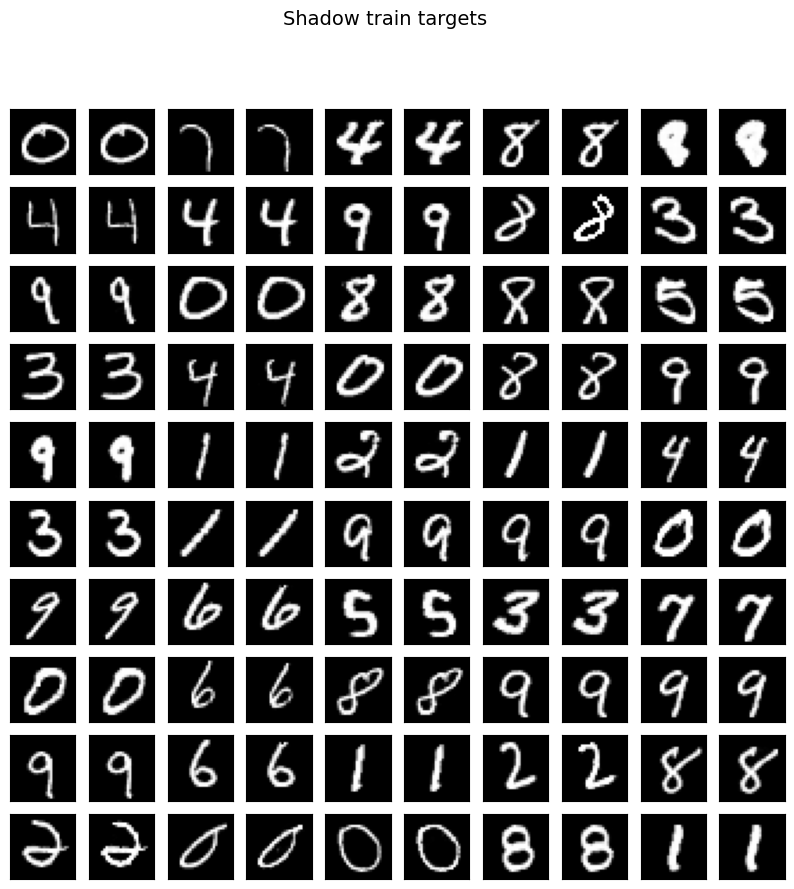

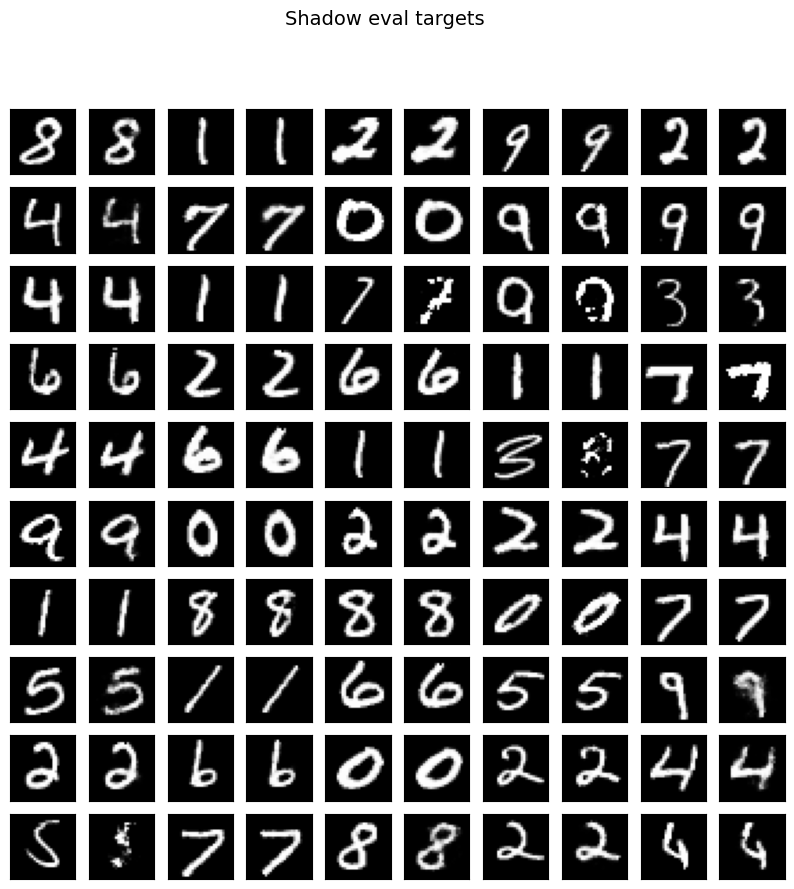

In [ ]:
batch_size = 50  #@param {type:"slider", min:1, max:50, step:1}


# Helper function to display digit images
def show_sample(images, sample_count=25, is_train=False):
  # Create a square with can fit {sample_count} images.
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images))
  plt.figure(figsize=(grid_count, grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.gray, vmin=0, vmax=1.)
  plt.suptitle(
      'Shadow train targets' if is_train else 'Shadow eval targets',
      fontsize=14)


images_train_logits = reconstructor_network.apply(
    opt_reconstructor_params, reconstruction_train_data.params[:batch_size])
images_train_pred = jax.nn.sigmoid(images_train_logits)
images_train_target = reconstruction_train_data.images[:batch_size]
images_to_plot = np.empty(
    (images_train_target.shape[0] + images_train_pred.shape[0],
     images_train_target.shape[1]))
images_to_plot[::2, :] = images_train_target
images_to_plot[1::2, :] = images_train_pred
images_to_plot = images_to_plot.reshape((images_to_plot.shape[0], 28, 28))
show_sample(images_to_plot, sample_count=images_to_plot.shape[0], is_train=True)

images_test_logits = reconstructor_network.apply(
    opt_reconstructor_params, reconstruction_eval_data.params[:batch_size])
images_test_pred = jax.nn.sigmoid(images_test_logits)
images_test_target = reconstruction_eval_data.images[:batch_size]
images_to_plot = np.empty(
    (images_test_target.shape[0] + images_test_pred.shape[0],
     images_test_target.shape[1]))
images_to_plot[::2, :] = images_test_target
images_to_plot[1::2, :] = images_test_pred
images_to_plot = images_to_plot.reshape((images_to_plot.shape[0], 28, 28))
show_sample(
    images_to_plot, sample_count=images_to_plot.shape[0], is_train=False)